In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numdifftools as nd
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
%matplotlib inline

### The Hull and White Model

The SDE of the short rate process $\{r(t)\}_{t\geq0}$, under the risk neutral measure, is given by:
$$dr(t)=[\vartheta(t)-ar(t)]dt + \sigma dW(t),$$
where $a$ and $\sigma$ are positive constants and the deterministic function $\vartheta$ is chosen so as to exactly fit the initial term structure of interest rates $T\mapsto B(0,T)$ as observed in the market. As a result, we must have,
$$\vartheta(t)=\frac{\partial}{\partial T}\big|_{T=t} f(0,t) + af(0,t) + \frac{\sigma^2}{2a}(1-e^{-2at}),$$
where $f(0,t)=-\frac{\partial}{\partial T}\big|_{T=t}\log B(0,t)$, is the instantaneous forward rate at time $0$ for the maturity $t$.

For the Hull and White model, a zero coupon bond $B(t,S)$ at time $t$ with maturity $S$, can be explicitly calculated through the formula $B(t,S)=A(t,S)e^{-C(t,S)r(t)}$, where
\begin{align*}
&C(t,S)=\frac{1}{a}\big[1-e^{-a(S-t)}\big]\
&A(t,S)=\frac{B(0,S)}{B(0,t)}\exp\big\{C(t,S)f(0,t)-\frac{\sigma^2}{4a}(1-e^{-2at})C(t,S)^2\big\}.
\end{align*}
Using this it can be deduced that, under the $S$-forward measure, the SDE is given by:
$$dr(t)=[\vartheta(t)-C(t,S)\sigma^2-ar(t)]dt + \sigma dW^S(t).$$
This new SDE will be used to generate paths of $r(t)$ upto a time $T\leq S$.

**Note:** Here I have used dummy values of $a$ and $\sigma$ to generate the short rate process. Ideally, these parameters should be estimated from the available swaption prices.

#### The initial zero-bond curve

This is a dummy curve obtained from replicating a plot shown in Brigo-Mercurio, figure 1.2.

Text(0, 0.5, 'Current Bond Price')

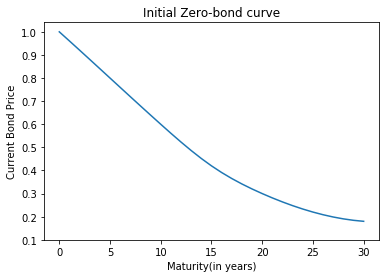

In [2]:
x_arr = [5*n for n in range(7)]
y_arr = [1,0.8,0.6,0.42,0.3,0.22,0.18]

# Interpolating a function with the given data points--> t vs B(0,t)
def initial_ts_bonds(t): 
    return float(interp1d(x_arr,y_arr,kind='cubic',fill_value='extrapolate')(t))  # using float as the interp1d output is an array

x_pts = np.arange(31)
y_pts = np.array([initial_ts_bonds(T) for T in x_pts])
plt.plot(x_pts,y_pts)
plt.title('Initial Zero-bond curve')
plt.xlabel('Maturity(in years)')
plt.yticks([0.1*n for n in range(1,11)])
plt.ylabel('Current Bond Price')

#### Setting the Hull and White parameters

In [3]:
# The constant parameters of Hull and White
a = 0.04642
sigma = 0.00586

def log_bond_curve(t):    # t vs logB(0,t)
    return np.log(initial_ts_bonds(t))

# instantaneous forward rate at time 0 with maturity t --> f(0,t)
def inst_forward_rate(t):
    return -float(nd.Derivative(log_bond_curve)(t))

# derivative of the above forward rate wrt T(= double derivative of the initial bond curve wrt T)
def derivative_forward_rate(t):
    return float(nd.Derivative(inst_forward_rate)(t))
    #return -float(nd.Derivative(log_bond_curve,order=4,n=2)(t))

# The deterministic function parameter of Hull and White
def HW_param1(t):  
    component1 = derivative_forward_rate(t) + a*inst_forward_rate(t)
    component2 = ( (sigma**2)/(2*a) ) * ( 1 - np.exp(-2*a*t) )
    return component1 + component2

In [4]:
# This is f(0,0)

inst_forward_rate(0)

0.039333333333334386

#### Simulating the short rate upto 1 year(under the 1yr-forward measure)

In [5]:
S = 5                  # Time to (swap)maturity = 5 yr
T = 1                  # Time to (swaption)maturity / short rate simulation final date = 1 yr

# Since f(t,t)=r(t), we'll set the initial short rate as f(0,0) obtained above
r0 = 0.039             # Initial short rate = 3.9% 
step = 0.01            # Simulation time step = 0.01 yr

# Defining the function C(t,S)
def C(t,S):
    return ( 1 - np.exp(-a*(S-t)) )/a

# Defining the function A(t,S)
def A(t,S):
    comp1 = initial_ts_bonds(S)/initial_ts_bonds(t)
    comp2 = C(t,S) * inst_forward_rate(t)
    comp3 = ( (sigma**2)/(4*a) ) * ( 1 - np.exp(-2*a*t) ) * ( C(t,S)**2 )
    return comp1 * np.exp( comp2 - comp3 )

#### Simulation under the risk neutral measure

In [6]:
# Initializing the matrix that will contain the short rate data simulated by HW model
# Rows of this matrix indicate different time steps upto final date of simulation
# Columns of this matrix indicate different paths
Simulated_rates_RN = np.zeros((101,1000))

Simulated_rates_RN[0] = r0    # Time 0 values of the short rate process along all the paths

for i in range(1,101):
    np.random.seed(i)
    comp1 = Simulated_rates_RN[i-1] + ( HW_param1(step*(i-1)) - a*Simulated_rates_RN[i-1] )*step
    comp2 = sigma * np.sqrt(step) * np.random.randn(1000)
    Simulated_rates_RN[i] = comp1 + comp2

In [7]:
# Final values of the short rate process along all paths(1000)
Simulated_rates_RN[-1]

array([0.0401915 , 0.04155163, 0.03667367, 0.0303522 , 0.03653884,
       0.03622309, 0.03213195, 0.04143118, 0.0377158 , 0.04210443,
       0.045814  , 0.04131609, 0.03489612, 0.03695001, 0.03772029,
       0.0349883 , 0.0484488 , 0.05230699, 0.04428529, 0.04359063,
       0.03384482, 0.02993276, 0.04709566, 0.04545842, 0.04002637,
       0.04042103, 0.04562945, 0.04217427, 0.04637795, 0.03410229,
       0.03918492, 0.03579857, 0.03212606, 0.03865013, 0.02834292,
       0.03417899, 0.03840988, 0.03937001, 0.03608159, 0.0428379 ,
       0.04547786, 0.03732713, 0.03752881, 0.04475478, 0.05150586,
       0.03747235, 0.03035364, 0.04969308, 0.03102358, 0.0454732 ,
       0.04229954, 0.03621263, 0.03385878, 0.04520628, 0.04096077,
       0.05477914, 0.04865335, 0.04415282, 0.03836381, 0.0394806 ,
       0.03967639, 0.03858937, 0.04087132, 0.04391919, 0.0453966 ,
       0.04115608, 0.04053151, 0.04227663, 0.04781992, 0.0524743 ,
       0.04771093, 0.04572701, 0.03841335, 0.04764498, 0.04834

#### Simulation under the S-forward measure

In [8]:
# Initializing the matrix that will contain the short rate data simulated by HW model
# Rows of this matrix indicate different time steps upto final date of simulation
# Columns of this matrix indicate different paths
Simulated_rates_fwd = np.zeros((101,1000))

Simulated_rates_fwd[0] = r0    # Time 0 values of the short rate process along all the paths

for i in range(1,101):
    np.random.seed(i)
    comp1 = Simulated_rates_fwd[i-1] + ( HW_param1(step*(i-1)) - C(step*(i-1),S)*(sigma**2) - a*Simulated_rates_fwd[i-1] )*step
    comp2 = sigma * np.sqrt(step) * np.random.randn(1000)
    Simulated_rates_fwd[i] = comp1 + comp2

In [9]:
# Final values of the short rate process along all paths(1000)
Simulated_rates_fwd[-1]

array([0.04005522, 0.04141536, 0.0365374 , 0.03021592, 0.03640256,
       0.03608681, 0.03199567, 0.0412949 , 0.03757952, 0.04196815,
       0.04567772, 0.04117981, 0.03475984, 0.03681373, 0.03758401,
       0.03485202, 0.04831252, 0.05217071, 0.04414901, 0.04345436,
       0.03370854, 0.02979648, 0.04695938, 0.04532214, 0.0398901 ,
       0.04028475, 0.04549318, 0.04203799, 0.04624168, 0.03396601,
       0.03904864, 0.03566229, 0.03198978, 0.03851385, 0.02820664,
       0.03404272, 0.03827361, 0.03923373, 0.03594531, 0.04270162,
       0.04534158, 0.03719085, 0.03739253, 0.04461851, 0.05136958,
       0.03733608, 0.03021737, 0.0495568 , 0.0308873 , 0.04533692,
       0.04216326, 0.03607635, 0.0337225 , 0.04507001, 0.0408245 ,
       0.05464286, 0.04851707, 0.04401654, 0.03822754, 0.03934432,
       0.03954012, 0.0384531 , 0.04073505, 0.04378291, 0.04526032,
       0.0410198 , 0.04039523, 0.04214035, 0.04768364, 0.05233803,
       0.04757465, 0.04559074, 0.03827708, 0.04750871, 0.04820

### Pricing a swaption

Consider a payer swaption with strike rate $K$, maturity $T$ and nominal value $N$, which gives the holder the right to enter into a payer swap at time at time $t_0=T$ with payment dates $t_1,\ldots,t_n=S,t_i>T$, where he pays at the fixed rate $K$ and receives at the floating(LIBOR) rate $L(t_{i-1},t_i)$.

The payoff of this swaption is given by 
$$N\Big(\sum_{i=1}^nB(T,t_i)(t_i-t_{i-1})\big[F(T,t_{i-1},t_i)-K\big]\Big)^+=N\big(1-\sum_{i=1}^nc_iB(T,t_i)\big)^+,$$
where $c_i=K(t_i-t_{i-1}),c_n=\big(1+K(t_i-t_{i-1})\big)$, and $F(T,t_{i-1},t_i)=\frac{B(T,t_{i-1})-B(T,t_i)}{(t_i-t_{i-1})B(T,t_i)}$ is the forward rate at time $T$ with expiry $t_{i-1}$ and maturity $t_i$, for $i\in\{1,\ldots,n\}$.

To compute the current price of this swaption, the following approaches will be used:
1. **Monte-Carlo Method**
2. **Jamshidian Decomposition**

Finally, it'll be assumed that the swaption is at the money, i.e., $K=\frac{B(0,T)-B(0,S)}{\sum_{i=1}^n(t_i-t_{i-1})B(0,t_i)}$, which is the swap rate of the underlying swap at time 0.

In [10]:
# The nominal value of the contract(= 100 USD)
N = 100             

# Time between the reset date and the next payment date
tau = 0.5          # 0.5 yrs = 6 months

# The payment and reset dates of the swaption
# 1st reset date = the swaption maturity
# 2nd reset date = 1st payment date, 3rd reset date = 2nd payment date, and so on. Last payment date(from current date) = 5 yrs
time_to_payment_dates = np.arange(T+tau,S+tau,tau)
print('Time to payment dates: ', time_to_payment_dates,'\n')

# The strike rate
K = ( initial_ts_bonds(T)-initial_ts_bonds(S) )/( tau*sum([initial_ts_bonds(t) for t in time_to_payment_dates]) )
print('The strike rate: ', K,'\n')

# The coupon amounts(=c_i)
coupon_values = np.array([K*tau for i in range(len(time_to_payment_dates)-1)] + [1+K*tau])
print('The coupon values: ', coupon_values)

Time to payment dates:  [1.5 2.  2.5 3.  3.5 4.  4.5 5. ] 

The strike rate:  0.046092690884860135 

The coupon values:  [0.02304635 0.02304635 0.02304635 0.02304635 0.02304635 0.02304635
 0.02304635 1.02304635]


#### Monte Carlo Method

To price the above swaption using Monte-Carlo method, $S$-forward measure will be used. With this, the current price is given by $NB(0,S)\mathbf{E}^S\big[\big(1-\sum_{i=1}^nc_iB(T,t_i)\big)^+\big/B(T,S)\big]$

Under the risk-neutral measure the price becomes
$N\mathbf{E}\big[D(T)\big(1-\sum_{i=1}^nc_iB(T,t_i)\big)^+\big]=N\mathbf{E}\big[\exp\big\{-\int_0^Tr(u)du\big\}\big(1-\sum_{i=1}^nc_iB(T,t_i)\big)^+\big]=N\mathbf{E}\big[\exp\big\{-\sum_{j=0}^{m-1}r(s_j)\Delta s_j\big\}\big(1-\sum_{i=1}^nc_iB(T,t_i)\big)^+\big]$

In [11]:
# Defining the function u->B(T,u), where T is the swaption maturity
# The output is an array as it contains the simulated values of the short rate at swaption maturity
def bondprice_at_swMaturity_RN(u):
    return np.array([ A(T,u)*np.exp(-C(T,u)*r) for r in Simulated_rates_RN[-1] ])

def bondprice_at_swMaturity_fwd(u):
    return np.array([ A(T,u)*np.exp(-C(T,u)*r) for r in Simulated_rates_fwd[-1] ])

#### Pricing under the Risk Neutral Measure

In [12]:
start = time.time()

# Step1: Finding the array within the expectation --> 1 - Sum of c_iB(T,t_i)
array1 = 1 - sum([c*bondprice_at_swMaturity_RN(t) for c,t in zip(coupon_values,time_to_payment_dates)])

# Step2: Choosing only the non-negative values from Step 1
array2 = np.array([max(x,0) for x in array1])

# Step3: Computing the discount factor at T
discount_factor_arr = np.exp(-step*sum([Simulated_rates_RN[i] for i in range(100)] ) )

# Step4: Computing the discounted payoff
array3 = discount_factor_arr * array2

# Step3: Computing the expectation
exp_value = array3.mean()

# Step4: Swaption price using the Monte-Carlo method
swaption_price_MC = N * exp_value
print('Price of the above swaption using Monte-Carlo method: ', swaption_price_MC,'\n')

end = time.time()
extime = end - start
print('Time required for this step: ', extime)

Price of the above swaption using Monte-Carlo method:  0.6964433509436447 

Time required for this step:  57.848597288131714


#### Pricing under the forward measure

In [13]:
start = time.time()

# Step1: Finding the array within the expectation --> 1 - Sum of c_iB(T,t_i)
array1 = 1 - sum([c*bondprice_at_swMaturity_fwd(t) for c,t in zip(coupon_values,time_to_payment_dates)])

# Step2: Choosing only the non-negative values from Step 1
array2 = np.array([max(x,0) for x in array1])

# Step3: Dividing array2 by B(T,S)
array3 = array2/bondprice_at_swMaturity_fwd(S)

# Step3: Computing the expectation
exp_value = array3.mean()

# Step4: Swaption price using the Monte-Carlo method
swaption_price_MC = N * initial_ts_bonds(S) * exp_value
print('Price of the above swaption using Monte-Carlo method: ', swaption_price_MC,'\n')

end = time.time()
extime = end - start
print('Time required for this step: ', extime)

Price of the above swaption using Monte-Carlo method:  0.6945843135937569 

Time required for this step:  66.14452457427979


#### Jamshidian Decomposition

To price the above swaption using Jamshidian decomposition, first one needs to solve the equation: $\sum_{i=1}^nc_iA(T,t_i)e^{-C(T,t_i)r}=1$, for $r$. In this case, the equation is (theoritically)solvable by the intermediate value theorem, due to the following reasons:
* The function $r\mapsto\sum_{i=1}^nc_iA(T,t_i)e^{-C(T,t_i)r}$ is continuous.
* Range of this function lies between $0$(as $r\rightarrow\infty$) and $\sum_{i=1}^nc_iA(T,t_i)$(when $r=0$).
* It can be checked that for the particular case at hand, $\sum_{i=1}^nc_iA(T,t_i)>1$.

Define $B(T,t_i,r)=A(T,t_i)e^{-C(T,t_i)r},F(T,t_i,r)=\sum_{i=1}^nc_iB(T,t_i,r)$, and note that all these functions are decreasing in $r$. Then the swaption payoff can be rewritten as:
\begin{align*}
N\big(F(T,t_i,r)-F(T,t_i,r(T))\big)^+&=N\big(F(T,t_i,r)-F(T,t_i,r(T))\big)I_{\{F(T,t_i,r)\geq F(T,t_i,r(T))\}}\\
&=N\big(F(T,t_i,r)-F(T,t_i,r(T))\big)I_{\{r\leq r(T)\}}\\
&=N\sum_{i=1}^nc_i\big(B(T,t_i,r)-B(T,t_i,r(T))\big)I_{\{r\leq r(T)\}}\\
&=N\sum_{i=1}^nc_i\big(B(T,t_i,r)-B(T,t_i,r(T))\big)I_{\{B(T,t_i,r)\geq B(T,t_i,r(T))\}}\\
&=N\sum_{i=1}^nc_i\big(B(T,t_i,r)-B(T,t_i,r(T))\big)^+
\end{align*}

So, the swaption price at time $t<T$ equals $N\sum_{i=1}^nc_i\text{ZBP}\big(t,T,t_i,B(T,t_i,r)\big)$, where $\text{ZBP}\big(t,T,S,X\big)$ is the time $t$ price of an European put option with strike $X$, maturity $T$ which is written on a zero coupon bond with maturity $S$.

It can be shown that $\text{ZBP}\big(t,T,S,X\big)=XB(t,T)N(-h+\sigma_p)-B(t,S)N(-h)$, where
* $\sigma_p=\sigma C(T,S)\sqrt{\frac{1-e^{-2a(T-t)}}{2a}}$,
* $h=\frac{1}{\sigma_p}\log\big(\frac{B(t,S)}{B(t,T)X}\big)+\frac{\sigma_p}{2}$,
* $N$ is the cdf of the standard normal.

In [14]:
# Checking that the sum c_iA(T,t_i) is greater than 1

sum([c*A(T,t) for c,t in zip(coupon_values,time_to_payment_dates)])

1.150376460660852

In [15]:
# Solving the equation in r

def eqFunction(r):
    return sum([c*A(T,t)*np.exp(-C(T,t)*r) for c,t in zip(coupon_values,time_to_payment_dates) ]) - 1

soln_r = fsolve(eqFunction,0)[0]
soln_r

0.04126849192432651

In [16]:
# Determining the strikes of European put on zero coupon bonds

strike_arr = np.array([A(T,t)*np.exp(-C(T,t)*soln_r) for t in time_to_payment_dates])
strike_arr

array([0.97932099, 0.95856012, 0.93772882, 0.91683844, 0.89590031,
       0.87492565, 0.85392565, 0.83291143])

In [17]:
# The price function of European put on zero coupon bonds at time 0
# option maturity-->t1, zero-coupon bond maturitty-->t2, option strike-->X

def ZBP(t1,t2,X):
    sigma_p = sigma * C(t1,t2) * np.sqrt( (1-np.exp(-2*a*t1))/(2*a) )
    h = (  (1/sigma_p) * np.log( initial_ts_bonds(t2)/(initial_ts_bonds(t1) * X) )  ) + (sigma_p/2)
    return X*initial_ts_bonds(t1)*norm.cdf(-h+sigma_p) - initial_ts_bonds(t2)*norm.cdf(-h)

In [18]:
# Determining the prices of European put on zero coupon bonds

price_arr = np.array([ZBP(T,t,strike) for t,strike in zip(time_to_payment_dates,strike_arr) ])
price_arr

array([0.00107372, 0.00207421, 0.00300383, 0.00386491, 0.00465976,
       0.00539063, 0.00605975, 0.00666929])

In [19]:
# Swaption price using Jamshidian Decomposition

swaption_price_JD = N * sum([c*price for c,price in zip(coupon_values,price_arr) ])
swaption_price_JD

0.7425124083718546